In [2]:
import random
import helpers
import numpy as np
import pandas as pd
from copy import copy
from genetic import Experiment,Population,Chromosome,Gen
from joblib import Parallel, delayed,parallel_backend
import time
from ExperimentBase2 import ExperimentBaseModel,Transformer,CAModel
from Visualization import Visualization
import matplotlib.pyplot as plt
import math

In [33]:
class Experiment1(ExperimentBaseModel):
    def __init__(self,data,name,path,verbose):
        ExperimentBaseModel.__init__(self,data,name,path,verbose)
        self.mem = {}
    
    def setupChromosome(self,chromosome,goal):
        keys = list(self.domain.keys())
        keys = sorted(keys)
        for key in keys:
            noChoices = random.randint(1,len(self.domain[key])//2)
            vals = set(random.choices(self.domain[key],k=noChoices))
            chromosome.genes.append(Gen(key,vals))
    
    def mutate(self,chromosome):
        if random.random() < self.mutationRate:
            index = random.randint(0,len(chromosome.genes)-1)
            identifier = chromosome.genes[index].identifier
            proportion =  len(self.domain[identifier]) - len(chromosome.genes[index].value)
            if proportion < random.random():
                val = random.choice(self.domain[identifier])
                chromosome.genes[index].value.add(val)
            else:
                if len(chromosome.genes[index].value) > 0:
                    el = random.choice(list(chromosome.genes[index].value))
                    chromosome.genes[index].value.remove(el)
    
    def crossover(self,parent1,parent2,population):
        setup = lambda x: self.setupChromosome(x,population.goal)
        crossover = lambda p1,p2: self.crossover(p1,p2,population)
        chromosome1 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome2 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome1.parents = [parent1,parent2]
        chromosome2.parents = [parent1,parent2]
        iGenes = list(range(len(parent1.genes)))#list(self.domain.keys())
        random.shuffle(iGenes)
        mid = len(iGenes)//2
        genes1 = [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[:mid]]
        genes1 += [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[mid:]]
        chromosome1.genes = sorted(genes1,key=lambda x: x.identifier)
        genes2 = [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[:mid]]
        genes2 += [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[mid:]]
        chromosome2.genes = sorted(genes2,key=lambda x: x.identifier)
        return [chromosome1,chromosome2]
    
    def express(self,chromosome):
        rule = "lambda summary2,goal: ["
        pos = []
        neg = []
        posMatch = []
        negMatch = []
        notZero = 0
        for gen in chromosome.genes:
            temp2 = []
            temp3 = []
            isZero = True
            for val in gen.value:
                if val != self.paddingValue:
                    isZero=False
                    temp = f"summary2[{gen.identifier}]['{val}'][goal] if goal in summary2[{gen.identifier}]['{val}'] else set()"
                    temp2.append(temp)
                    for goal in self.goals:
                        if goal != self.paddingValue:
                            temp3.append(f"summary2[{gen.identifier}]['{val}']['{goal}'] if goal != '{goal}' and '{goal}' in summary2[{gen.identifier}]['{val}'] else set()")
            notZero += 1 if not isZero else 0
            pos.append(f"set([]).union(*[{','.join(temp2)}])")
            neg.append(f"set([]).union(*[{','.join(temp3)}])")
        rule += f"[{','.join(pos)}],[{','.join(neg)}],{notZero if notZero > 0 else 100000}"+"]"
        return rule
    
    def getTotalMatch(self,phenotype,goal):
        totalNeg = 0
        totalPos = 0
        matchProportion = eval(phenotype)
        totalPosMatch,totalNegMatch,noChromosomes = matchProportion(self.summarized2,goal)
        countPosMatch = 0
        for row in totalPosMatch:
            for col in row:
                countPosMatch += self.matrix[col][1]
        countPosMatch = countPosMatch / noChromosomes
        countNegMatch = 0
        for row in totalNegMatch:
            for col in row:
                countNegMatch += self.matrix[col][1]
        countNegMatch = countNegMatch / noChromosomes
        totalPos = self.summarized["total"][goal]
        totalNeg = self.summarized["total"]["total"]-self.summarized["total"][goal]
        totalExamples = totalNeg+totalPos
        posProp = (totalPos/totalExamples) 
        negProp = (totalNeg/totalExamples) 
        total = (countPosMatch * negProp) + (-1*countNegMatch * posProp)
        maxTotal = (totalPos * negProp)
        res = total/maxTotal
        return res
    
    def regulation(self,population):
        population.chromosomes = sorted(population.chromosomes,key = lambda x:x.fitness,reverse = True)
        mid = self.noChromosomes // 2
        indexes = [x for x in range(1,len(population.chromosomes))]
        random.shuffle(indexes)
        indexes = indexes[:self.noChromosomes]
        firstHalf = indexes[:mid]
        secondHalf = indexes[mid:]
        selected = [population.chromosomes[0]]
        selected += (np.array(population.chromosomes)[firstHalf]).tolist()
        selected += (np.array(population.chromosomes)[secondHalf]).tolist()
        population.chromosomes = selected
    
    def setup(self):
        self.radious = 6
        self.neighborhood = helpers.moore([self.radious])
        self.mutationRate = .5
        self.noChromosomes = 50
        self.noIterations = 200
        self.paddingValue = "@"
        super().setup()

In [34]:
class Testing1():
    def __init__(self,data,model,verbose=0):
        self.data = data
        self.model = model
        self.verbose = verbose
    
    def testRow(self,row_prev,row,row_pred):
        totalMatchDynamic = 0
        totalMatchStatic = 0
        totalStatic = 0
        totalDynamic = 0
        for cell0,cell1,cell2 in zip(row_prev,row,row_pred):
            totalMatchDynamic += (cell0 != cell1 and cell1 == cell2)
            totalMatchStatic += (cell0 == cell1 and cell1 == cell2)
            totalStatic += (cell0 == cell1)
            totalDynamic += (cell0 != cell1)
        totalStatic = totalStatic if totalStatic > 0 else 0
        totalDynamic = totalDynamic if totalDynamic > 0 else 0
        return [totalStatic,totalDynamic,totalMatchStatic,totalMatchDynamic]
            
    def run(self):
        res = []
        backend = "threading"
        with Parallel(n_jobs=4,backend=backend) as parallel:
            if self.verbose >= 1: print("Testing:")
            for i in range(1,len(data)):
                if self.verbose >= 1: print(f"state {i}/{len(data)}")
                prediction = next(model.run(data[i-1],1))
                rowsTotal = parallel(delayed(self.testRow)(row0,row1,row2) for row0,row1,row2 in zip(data[i-1],data[i],prediction[1]))
                summation = np.sum(rowsTotal,axis=0)
                if self.verbose >= 1: 
                    print(f"Static : {summation[2]}/{summation[0]}")
                    print(f"Dynamic : {summation[3]}/{summation[1]}")
                totalStatic = summation[2]/summation[0] if summation[0] > 0 else 0
                totalDynamic = summation[3]/summation[1] if summation[1] > 0 else 0
                res.append([totalStatic,totalDynamic])
        self.result = np.array(res)
    
    def plot(self):
        plt.plot(range(len(self.result)),self.result[:,0])
        plt.plot(range(len(self.result)),self.result[:,1])
        return plt

dataframe = pd.read_csv("data/2_square.csv")
data  = dataframe.values
exp = Experiment1(data,"Experiment1","path")
exp.run()

In [35]:
data = "Había una vez un pueblo pequeño. Un pueblo con casas de piedras, calles retorcidas y muchos, muchos gatos. Los gatos vivían allí felices, de casa en casa durante el día, de tejado en tejado durante la noche. La convivencia entre las personas y los gatos era perfecta. Los humanos les dejaban campar a sus anchas por sus casas, les acariciaban el lomo, y le daban de comer. A cambio, los felinos perseguían a los ratones cuando estos trataban de invadir las casas y les regalaban su compañía las tardes de lluvia. Y no había quejas… Hasta que llegó Misifú. Al principio, este gato de pelaje blanco y largos bigotes hizo exactamente lo mismo que el resto: merodeaba por los tejados, perseguía ratones, se dejaba acariciar las tardes de lluvia. Pero pronto, el gato Misifú se aburrió de hacer siempre lo mismo, de que la vida gatuna en aquel pueblo de piedra se limitara a aquella rutina y dejó de salir a cazar ratones. Se pasaba las noches mirando a la luna. Te vas a quedar tonto de tanto mirarla le decían sus amigos. Pero Misifú no quería escucharles. No era la luna lo que le tenía enganchado, sino aquel aire de magia que tenían las noches en los que su luz invadía todos los rincones. ¿No ves que no conseguirás nada? Por más que la mires, la luna no bajará a estar contigo. Pero Misifú no quería que la luna bajara a hacerle compañía. Le valía con sentir la dulzura con la que impregnaba el cielo cuando brillaba con todo su esplendor. Porque aunque nadie parecía entenderlo, al gato Misifú le gustaba lo que esa luna redonda y plateada le hacía sentir, lo que le hacía pensar, lo que le hacía soñar. Mira la luna. Es grande, brillante y está tan lejos. ¿No podremos llegar nosotros ahí donde está ella? ¿No podremos salir de aquí, ir más allá? preguntaba Misifú a su amiga Ranina. Ranina se estiraba con elegancia y le lanzaba un gruñido. ¡Ay que ver, Misifú! ¡Cuántos pájaros tienes en la cabeza! Pero Misifú no tenía pájaros sino sueños, muchos y quería cumplirlos todos… Tendríamos que viajar, conocer otros lugares, perseguir otros animales y otras vidas. ¿Es que nuestra existencia va a ser solo esto? Muy pronto los gatos de aquel pueblo dejaron de hacerle caso. Hasta su amiga Ranina se cansó de escucharle suspirar. Tal vez por eso, tal vez porque la luna le dio la clave, el gato Misifú desapareció un día del pueblo de piedra. Nadie consiguió encontrarle. Se ha marchado a buscar sus sueños. ¿Habrá llegado hasta la luna? se preguntaba con curiosidad Ranina… Nunca más se supo del gato Misifú, pero algunas noches de luna llena hay quien mira hacia el cielo y puede distinguir entre las manchas oscuras de la luna unos bigotes alargados."
data = np.array([np.array(list(w.ljust(12," "))) for w in data.split(" ")])
maxLength = -1
for i,w in enumerate(data):
    if len(w) > len(data[maxLength]):
        maxLength = i
print(len(data[maxLength]))

12


In [ ]:
#data  = np.load("data/data_gray.npy")
#data = data[:,50:100,50:250]
print(np.shape(data))
train = math.floor(len(data) * 0.8)
print(np.shape(data[:train]))
exp2 = Experiment1(data[:train],"Experiment5","text",verbose=2)
exp2.run()

In [28]:
transformer = Transformer(exp2)
model = transformer.getModel()

In [30]:
prediction = []
for it in model.run(data[0],50):
    prediction.append(it[1])

In [31]:
prediction

[array(['E', 'E', 'E', 'E', 'E', 'E', '!', ' ', ' ', '!', ' ', ' '],
       dtype='<U1'),
 array(['E', 'C', 'E', 'E', 'C', 'E', 'E', ' ', ' ', '!', ' ', ' '],
       dtype='<U1'),
 array(['E', 'q', 'E', 'E', 'C', 'E', 'E', ' ', ' ', '!', ' ', ' '],
       dtype='<U1'),
 array(['E', 'q', 'E', 'E', 'C', 'E', 'E', ' ', ' ', '!', ' ', ' '],
       dtype='<U1'),
 array(['E', 'q', 'E', 'E', 'C', 'E', 'E', ' ', ' ', '!', ' ', ' '],
       dtype='<U1'),
 array(['E', 'q', 'E', 'E', 'C', 'E', 'E', ' ', ' ', '!', ' ', ' '],
       dtype='<U1'),
 array(['E', 'q', 'E', 'E', 'C', 'E', 'E', ' ', ' ', '!', ' ', ' '],
       dtype='<U1'),
 array(['E', 'q', 'E', 'E', 'C', 'E', 'E', ' ', ' ', '!', ' ', ' '],
       dtype='<U1'),
 array(['E', 'q', 'E', 'E', 'C', 'E', 'E', ' ', ' ', '!', ' ', ' '],
       dtype='<U1'),
 array(['E', 'q', 'E', 'E', 'C', 'E', 'E', ' ', ' ', '!', ' ', ' '],
       dtype='<U1'),
 array(['E', 'q', 'E', 'E', 'C', 'E', 'E', ' ', ' ', '!', ' ', ' '],
       dtype='<U1'),
 array(['E

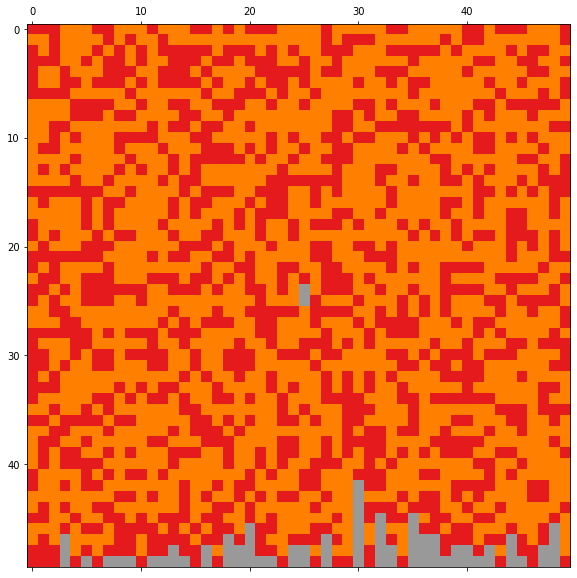

In [20]:
helpers.animate(prediction)

Testing:
state 1/472
Static : 4/7
Dynamic : 0/5
state 2/472
Static : 4/9
Dynamic : 0/3
state 3/472
Static : 5/9
Dynamic : 0/3
state 4/472
Static : 4/6
Dynamic : 0/6
state 5/472
Static : 3/5
Dynamic : 0/7
state 6/472
Static : 3/4
Dynamic : 0/8
state 7/472
Static : 4/6
Dynamic : 0/6
state 8/472
Static : 3/6
Dynamic : 0/6
state 9/472
Static : 4/8
Dynamic : 0/4
state 10/472
Static : 4/7
Dynamic : 0/5
state 11/472
Static : 4/4
Dynamic : 0/8
state 12/472
Static : 2/4
Dynamic : 0/8
state 13/472
Static : 2/2
Dynamic : 0/10
state 14/472
Static : 2/2
Dynamic : 0/10
state 15/472
Static : 5/5
Dynamic : 0/7
state 16/472
Static : 6/11
Dynamic : 0/1
state 17/472
Static : 5/6
Dynamic : 0/6
state 18/472
Static : 5/6
Dynamic : 0/6
state 19/472
Static : 5/7
Dynamic : 0/5
state 20/472
Static : 5/6
Dynamic : 0/6
state 21/472
Static : 4/7
Dynamic : 0/5
state 22/472
Static : 3/5
Dynamic : 0/7
state 23/472
Static : 4/5
Dynamic : 0/7
state 24/472
Static : 5/8
Dynamic : 0/4
state 25/472
Static : 4/8
Dynamic : 0

<module 'matplotlib.pyplot' from '/Users/hectormoreno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

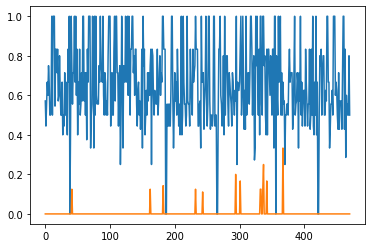

In [32]:
test1 = Testing1(data,model,verbose=1)
test1.run()
test1.plot()

In [3]:
visualization = Visualization("text/14_01_20_18_10_12")

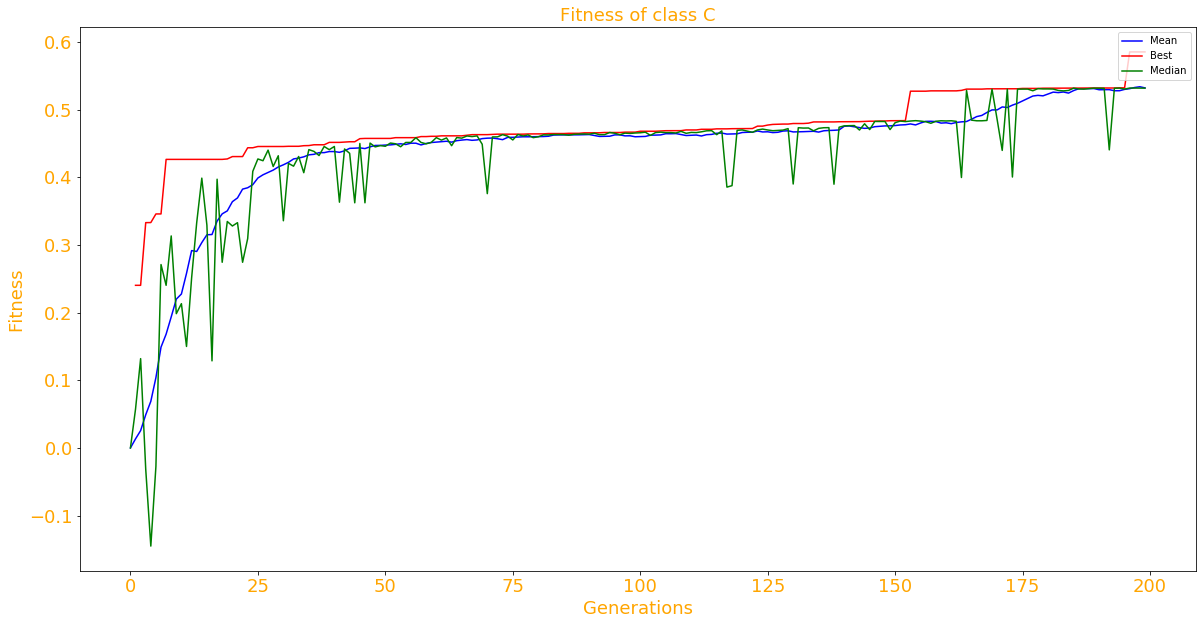

In [8]:
visualization.getFitnessGraph("C")

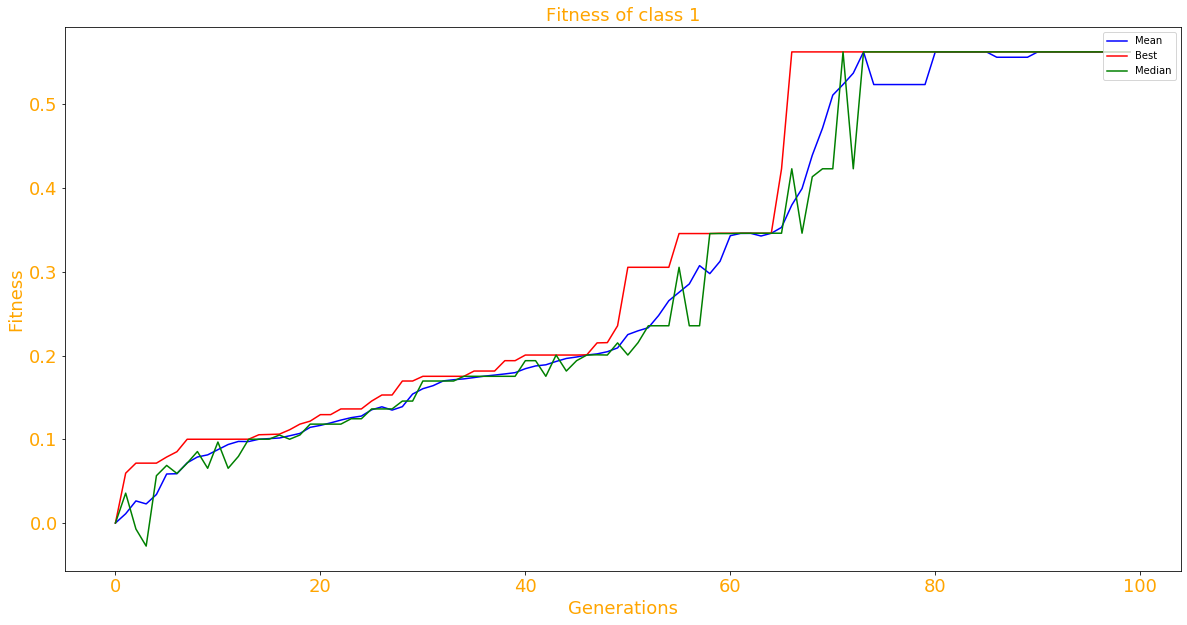

In [15]:
visualization.getFitnessGraph("1")

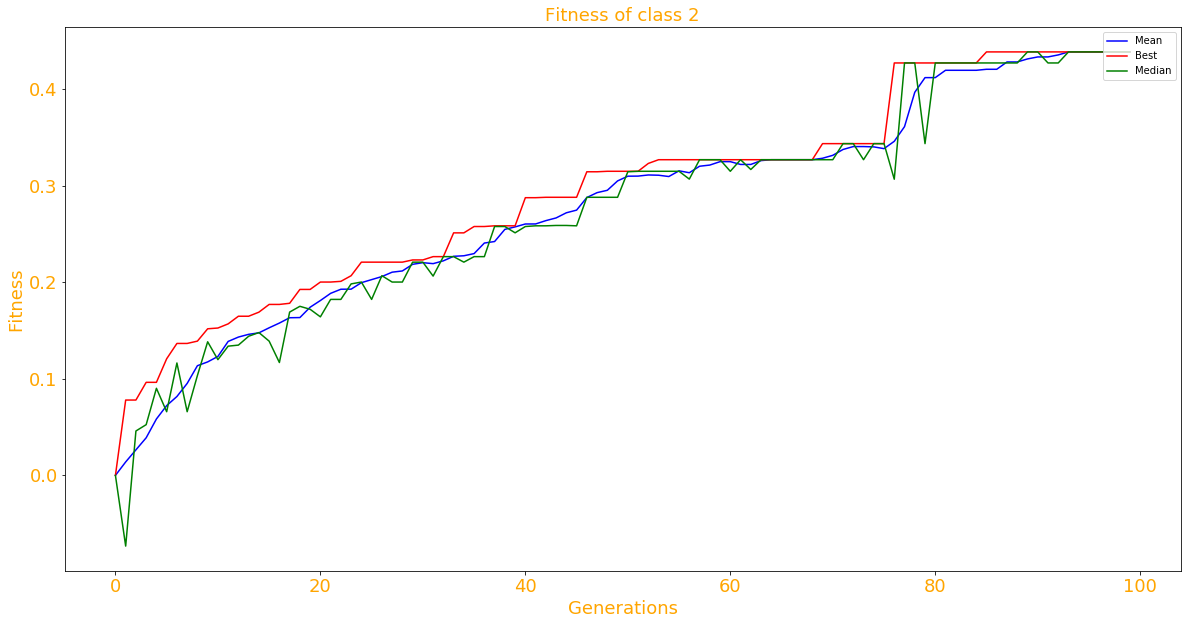

In [16]:
visualization.getFitnessGraph("2")

In [29]:
transformer.lmstr

{' ': "lambda x: (x[0] in {'z', ' ', 'c'} if x[0] != '@' else True) and (x[1] in {'a', ',', ' ', ':'} if x[1] != '@' else True) and (x[2] in {'o', 't', ' ', 'T'} if x[2] != '@' else True) and (x[3] in {'f', ' ', 'ñ'} if x[3] != '@' else True) and (x[4] in {'f', '.', ' '} if x[4] != '@' else True) and (x[5] in {' '} if x[5] != '@' else True)",
 'n': "lambda x: (x[7] in {'a', 'b', 'g'} if x[7] != '@' else True) and (x[11] in {' '} if x[11] != '@' else True) and (x[12] in {' '} if x[12] != '@' else True)",
 'u': "lambda x: (x[9] in {'o', ' '} if x[9] != '@' else True) and (x[11] in {'a', ' '} if x[11] != '@' else True) and (x[12] in {' '} if x[12] != '@' else True)",
 'z': "lambda x: (x[12] in {' '} if x[12] != '@' else True)",
 'e': "lambda x: (x[5] in {'¿', 'd'} if x[5] != '@' else True) and (x[7] in {'l', 'm'} if x[7] != '@' else True) and (x[8] in {'o', 'e', 'n'} if x[8] != '@' else True) and (x[9] in {'n', 'm'} if x[9] != '@' else True) and (x[10] in {' '} if x[10] != '@' else True) 

In [26]:
import sys
del sys.modules["ExperimentBase2"]